In [ ]:
import os
import pandas as pd

# Directory containing CSVs
data_dir = "/content"

# Initialize list for all patient dataframes
all_data = []

# Loop through CSVs
for file in sorted(os.listdir(data_dir)):
    if file.endswith(".csv"):
        patient_id = int(file[1:3])  # Extract patient number from filename s01r01.csv
        if patient_id in [4, 10]:    # Exclude patients 4 and 10
            continue

        df = pd.read_csv(os.path.join(data_dir, file))
        df['patient'] = patient_id
        df['recording'] = file

        # CRITICAL FIX: Filter out annotation = 0 (not part of experiment)
        df = df[df['annotation'] != 0].reset_index(drop=True)

        all_data.append(df)

# Combine all patients into a single dataframe
combined_df = pd.concat(all_data, ignore_index=True)

# Show combined shape and annotation distribution
print("Combined DataFrame shape:", combined_df.shape)
print("\nAnnotation distribution (after filtering out annotation=0):")
print(combined_df['annotation'].value_counts())
print("\nAnnotation 1 (walk) and 2 (FoG) only - annotation 0 excluded")
print("\nColumns in dataset:")
print(combined_df.columns.tolist())

Combined DataFrame shape: (844510, 13)

Annotation distribution (after filtering out annotation=0):
annotation
1    733725
2    110785
Name: count, dtype: int64

Annotation 1 (walk) and 2 (FoG) only - annotation 0 excluded

Columns in dataset:
['time_of_sample', 'ankle_horizontal_forward_acceleration', 'ankle_vertical', 'ankle_horizontal_lateral', 'upper_leg_horizontal_forward_acceleration', 'upper_leg_vertical', 'upper_leg_horizontal_lateral', 'trunk_horizontal_forward_acceleration', 'trunk_vertical', 'trunk_horizontal_lateral', 'annotation', 'patient', 'recording']


In [ ]:
from scipy.signal import butter, filtfilt

# Sampling rate and cutoff
fs = 64  # Hz
cutoff = 20  # Hz

# Butterworth filter coefficients
b, a = butter(N=3, Wn=cutoff/(fs/2), btype='low')

# List of columns to filter (all accelerometer axes)
imu_columns = [
    'ankle_horizontal_forward_acceleration',
    'ankle_vertical',
    'ankle_horizontal_lateral',
    'upper_leg_horizontal_forward_acceleration',
    'upper_leg_vertical',
    'upper_leg_horizontal_lateral',
    'trunk_horizontal_forward_acceleration',
    'trunk_vertical',
    'trunk_horizontal_lateral'
]

# CRITICAL FIX: Filter each recording separately to avoid boundary artifacts
filtered_dfs = []

for recording in combined_df['recording'].unique():
    # Get data for this recording
    rec_df = combined_df[combined_df['recording'] == recording].copy()

    # Apply filter to each IMU column
    for col in imu_columns:
        rec_df[col + '_filt'] = filtfilt(b, a, rec_df[col].values)

    filtered_dfs.append(rec_df)

# Concatenate all filtered recordings
combined_df = pd.concat(filtered_dfs, ignore_index=True)

print("Filtered columns added.")
print(f"Total recordings processed: {len(filtered_dfs)}")
print(f"Final shape: {combined_df.shape}")
print("\nExample of original vs filtered (first accelerometer column):")
print(combined_df[[imu_columns[0], imu_columns[0] + '_filt']].head())
print("\nColumns now available:")
print([col for col in combined_df.columns if '_filt' in col])

Filtered columns added.
Total recordings processed: 14
Final shape: (844510, 22)

Example of original vs filtered (first accelerometer column):
   ankle_horizontal_forward_acceleration  \
0                                    -30   
1                                    -30   
2                                    -20   
3                                    -20   
4                                      0   

   ankle_horizontal_forward_acceleration_filt  
0                                  -30.006663  
1                                  -28.182928  
2                                  -23.811963  
3                                  -14.354459  
4                                   -6.730272  

Columns now available:
['ankle_horizontal_forward_acceleration_filt', 'ankle_vertical_filt', 'ankle_horizontal_lateral_filt', 'upper_leg_horizontal_forward_acceleration_filt', 'upper_leg_vertical_filt', 'upper_leg_horizontal_lateral_filt', 'trunk_horizontal_forward_acceleration_filt', 'trunk_vertical_

In [ ]:
import numpy as np
import pandas as pd

def create_window_index_labels_augmented(df, window_sec=2, transition_sec=2, fs=64, overlap_ratio=0.5):
    """
    Augmented version: Uses OVERLAPPING windows to increase dataset size.
    overlap_ratio: 0.0 = no overlap (original), 0.5 = 50% overlap, 0.75 = 75% overlap.
    """
    window_size = int(window_sec * fs)
    transition_samples = int(transition_sec * fs)

    # stride: how many samples to move the window forward
    # if overlap is 0.5, we move forward by half a window
    stride = int(window_size * (1 - overlap_ratio))
    if stride < 1: stride = 1

    walk_windows = []
    transition_windows = []
    fog_windows = []

    for patient in df['patient'].unique():
        for recording in df[df['patient'] == patient]['recording'].unique():
            rec_df = df[(df['patient'] == patient) & (df['recording'] == recording)].reset_index(drop=True)
            ann = rec_df['annotation'].values
            n_samples = len(rec_df)

            # Find FoG events
            fog_events = []
            i = 0
            while i < n_samples:
                if ann[i] == 2:
                    fog_start = i
                    while i < n_samples and ann[i] == 2:
                        i += 1
                    fog_end = i
                    fog_events.append((fog_start, fog_end))
                else:
                    i += 1

            for fog_start, fog_end in fog_events:

                # --- 1. Create OVERLAPPING TRANSITION Windows ---
                # We define the "Transition Zone" as [fog_start - transition_samples : fog_start]
                # We slide the window across this zone

                # Start sliding from the beginning of the transition zone
                zone_start = fog_start - transition_samples
                zone_end = fog_start

                # Generate multiple windows ending within this zone
                # To be a valid transition window, the window must END inside the transition zone
                # and START after the zone_start

                # Let's slide strictly: distinct windows ending at fog_start, fog_start - stride, etc.
                # We work backwards from FoG onset to ensure we catch the critical moment
                curr_end = zone_end
                while curr_end - window_size >= zone_start - (transition_samples * 0.5): # Allow capturing a bit before
                    start_idx = curr_end - window_size
                    if start_idx >= 0:
                        transition_windows.append({
                            'patient': patient, 'recording': recording,
                            'start_idx': start_idx, 'end_idx': curr_end, 'label': 2
                        })
                    curr_end -= stride
                    # Limit to reasonable number per event to prevent massive imbalance
                    if len(transition_windows) > 10000: break

                # --- 2. Create OVERLAPPING FOG Windows ---
                curr_start = fog_start
                while curr_start + window_size <= fog_end:
                    fog_windows.append({
                        'patient': patient, 'recording': recording,
                        'start_idx': curr_start,
                        'end_idx': curr_start + window_size,
                        'label': 1
                    })
                    curr_start += stride

            # --- 3. Create OVERLAPPING WALK Windows ---
            walk_segments = []
            i = 0
            while i < n_samples:
                if ann[i] == 1:
                    start = i
                    while i < n_samples and ann[i] == 1:
                        i += 1
                    walk_segments.append((start, i))
                else:
                    i += 1

            for w_start, w_end in walk_segments:
                for start in range(w_start, w_end - window_size + 1, stride):
                    end = start + window_size

                    # Safety check: Don't overlap with Transition Zone
                    too_close = False
                    for fog_start, _ in fog_events:
                        if end > (fog_start - transition_samples) and start < fog_start:
                            too_close = True
                            break

                    if not too_close:
                        walk_windows.append({
                            'patient': patient, 'recording': recording,
                            'start_idx': start, 'end_idx': end, 'label': 0
                        })

    # Balancing
    n_fog = len(fog_windows)
    n_trans = len(transition_windows)

    # Limit the majority classes to 1.5x the minority to keep some balance but maximize data
    target_count = max(n_fog, n_trans)

    # Convert to DF
    walk_df = pd.DataFrame(walk_windows)
    trans_df = pd.DataFrame(transition_windows)
    fog_df = pd.DataFrame(fog_windows)

    # Downsample Walk if it's massive (it usually is)
    if len(walk_df) > target_count:
        walk_df = walk_df.sample(n=target_count, random_state=42)

    # Balance FoG and Trans if heavily skewed
    min_class = min(len(fog_df), len(trans_df))
    if len(fog_df) > min_class * 2: fog_df = fog_df.sample(n=min_class * 2, random_state=42)
    if len(trans_df) > min_class * 2: trans_df = trans_df.sample(n=min_class * 2, random_state=42)

    window_df = pd.concat([walk_df, trans_df, fog_df], ignore_index=True)

    print(f"\nAugmented {window_sec}s windows (Overlap={overlap_ratio}):")
    print(f"Total: {len(window_df)}")
    print(f"  Walk: {len(walk_df)}")
    print(f"  FoG: {len(fog_df)}")
    print(f"  Trans: {len(trans_df)}")

    return window_df

# Create datasets A, B, C as per paper
print("="*60)
print("DATASET A: 2s windows, 2s transition period")
print("="*60)
window_df_2s = create_window_index_labels_augmented(combined_df, window_sec=2, transition_sec=2, overlap_ratio=0.75)

print("\n" + "="*60)
print("DATASET B: 3s windows, 3s transition period")
print("="*60)
window_df_3s = create_window_index_labels_augmented(combined_df, window_sec=3, transition_sec=3, overlap_ratio=0.75)

print("\n" + "="*60)
print("DATASET C: 4s windows, 4s transition period")
print("="*60)
window_df_4s = create_window_index_labels_augmented(combined_df, window_sec=4, transition_sec=4, overlap_ratio=0.75)

DATASET A: 2s windows, 2s transition period

Augmented 2s windows (Overlap=0.75):
Total: 4818
  Walk: 2685
  FoG: 1422
  Trans: 711

DATASET B: 3s windows, 3s transition period

Augmented 3s windows (Overlap=0.75):
Total: 3710
  Walk: 1577
  FoG: 1422
  Trans: 711

DATASET C: 4s windows, 4s transition period

Augmented 4s windows (Overlap=0.75):
Total: 2787
  Walk: 1038
  FoG: 1038
  Trans: 711


Total FoG events: 237
FoG duration stats (seconds):
  Min: 0.44
  Max: 40.53
  Mean: 7.30
  Median: 5.34

FoG events shorter than 2s: 48
FoG events shorter than 3s: 72
FoG events shorter than 4s: 94


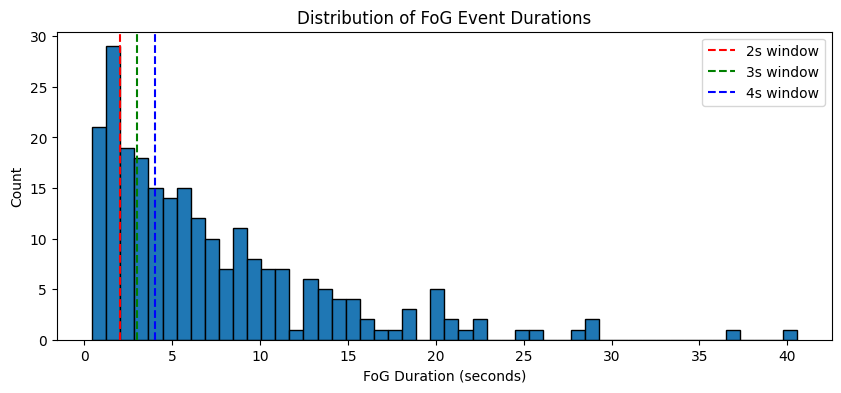

In [ ]:
# Check FoG event durations
fog_durations = []

for patient in combined_df['patient'].unique():
    for recording in combined_df[combined_df['patient'] == patient]['recording'].unique():
        rec_df = combined_df[(combined_df['patient'] == patient) & (combined_df['recording'] == recording)].reset_index(drop=True)
        ann = rec_df['annotation'].values
        n_samples = len(rec_df)

        i = 0
        while i < n_samples:
            if ann[i] == 2:  # Start of FoG
                fog_start = i
                while i < n_samples and ann[i] == 2:
                    i += 1
                fog_end = i
                duration_sec = (fog_end - fog_start) / 64  # Convert to seconds
                fog_durations.append(duration_sec)
            else:
                i += 1

import matplotlib.pyplot as plt

print(f"Total FoG events: {len(fog_durations)}")
print(f"FoG duration stats (seconds):")
print(f"  Min: {np.min(fog_durations):.2f}")
print(f"  Max: {np.max(fog_durations):.2f}")
print(f"  Mean: {np.mean(fog_durations):.2f}")
print(f"  Median: {np.median(fog_durations):.2f}")
print(f"\nFoG events shorter than 2s: {np.sum(np.array(fog_durations) < 2)}")
print(f"FoG events shorter than 3s: {np.sum(np.array(fog_durations) < 3)}")
print(f"FoG events shorter than 4s: {np.sum(np.array(fog_durations) < 4)}")

plt.figure(figsize=(10, 4))
plt.hist(fog_durations, bins=50, edgecolor='black')
plt.xlabel('FoG Duration (seconds)')
plt.ylabel('Count')
plt.title('Distribution of FoG Event Durations')
plt.axvline(2, color='r', linestyle='--', label='2s window')
plt.axvline(3, color='g', linestyle='--', label='3s window')
plt.axvline(4, color='b', linestyle='--', label='4s window')
plt.legend()
plt.show()

In [ ]:
import numpy as np
from scipy.stats import skew, kurtosis, entropy

def compute_time_features(sig):
    """
    Compute robust time-domain features for a 1D signal.
    Handles constant signals safely to avoid histogram errors in entropy.
    """
    sig = np.asarray(sig)
    rms = np.sqrt(np.mean(sig**2))
    vel_rms = np.sqrt(np.mean(np.diff(sig)**2)) if len(sig) > 1 else 0.0

    # Entropy computation
    data_range = np.max(sig) - np.min(sig)
    if data_range < 1e-6:
        ent = 0.0
    else:
        ps = np.histogram(sig, bins=10, density=True)[0] + 1e-8
        ent = -np.sum(ps * np.log(ps))

    return {
        'mean': np.mean(sig),
        'std': np.std(sig),
        'min': np.min(sig),
        'max': np.max(sig),
        'q1': np.percentile(sig, 25),
        'median': np.median(sig),
        'q3': np.percentile(sig, 75),
        'skew': skew(sig),
        'kurt': kurtosis(sig),
        'zero_cross': ((sig[:-1] * sig[1:]) < 0).sum() / len(sig),
        'ptp': np.ptp(sig),
        'crest_factor': np.max(np.abs(sig)) / (rms + 1e-8),
        'rms': rms,
        'vel_rms': vel_rms,
        'entropy': ent
    }

# Test
sig_test = np.array([1,1,1,1,1])
print("Time-domain features test:", compute_time_features(sig_test))


Time-domain features test: {'mean': np.float64(1.0), 'std': np.float64(0.0), 'min': np.int64(1), 'max': np.int64(1), 'q1': np.float64(1.0), 'median': np.float64(1.0), 'q3': np.float64(1.0), 'skew': np.float64(nan), 'kurt': np.float64(nan), 'zero_cross': np.float64(0.0), 'ptp': np.int64(0), 'crest_factor': np.float64(0.9999999900000002), 'rms': np.float64(1.0), 'vel_rms': np.float64(0.0), 'entropy': 0.0}


/tmp/ipython-input-3737695984.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': skew(sig),
/tmp/ipython-input-3737695984.py:30: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurt': kurtosis(sig),


In [ ]:
from scipy.signal import welch
from scipy.fft import fft, fftfreq

def compute_freq_features(sig, fs=64):
    """
    Compute comprehensive frequency-domain features using Welch's method and FFT.
    Includes all features from the paper (Table 1).
    """
    sig = np.asarray(sig)

    # Handle constant signal
    if np.all(sig == sig[0]) or len(sig) < 2:
        return {
            'freeze_index': 0.0,
            'power_diff': 0.0,
            'total_power': 0.0,
            'spectral_centroid': 0.0,
            'spectral_entropy': 0.0,
            'dom_freq': 0.0,
            'fft_mean_mag': 0.0,
            'fft_mean_phase': 0.0,
            'fft_coef_1': 0.0,
            'fft_coef_2': 0.0,
            'power_band_05_3': 0.0,
            'power_band_3_8': 0.0,
            'power_band_8_20': 0.0
        }

    # ===== WELCH'S METHOD FOR POWER SPECTRAL DENSITY =====
    f, Pxx = welch(sig, fs=fs, nperseg=min(len(sig), 256))
    total_power = np.sum(Pxx)

    # Frequency band powers
    p05_3 = np.sum(Pxx[(f >= 0.5) & (f < 3)])    # 0.5-3 Hz
    p3_8 = np.sum(Pxx[(f >= 3) & (f < 8)])       # 3-8 Hz
    p8_20 = np.sum(Pxx[(f >= 8) & (f <= 20)])    # 8-20 Hz

    # Freeze Index (key feature for FoG detection)
    freeze_index = p3_8 / (p05_3 + 1e-8)

    # Power difference
    power_diff = p3_8 - p05_3

    # Dominant frequency
    dom_freq = f[np.argmax(Pxx)]

    # Spectral centroid (center of mass of spectrum)
    spectral_centroid = np.sum(f * Pxx) / (total_power + 1e-8)

    # Spectral entropy
    Pxx_norm = Pxx / (total_power + 1e-8)
    spectral_entropy = -np.sum(Pxx_norm * np.log(Pxx_norm + 1e-8))

    # ===== FFT FEATURES =====
    # Compute FFT
    N = len(sig)
    fft_vals = fft(sig)
    fft_freqs = fftfreq(N, 1/fs)

    # Take only positive frequencies
    positive_freq_idx = fft_freqs > 0
    fft_vals_pos = fft_vals[positive_freq_idx]
    fft_freqs_pos = fft_freqs[positive_freq_idx]

    # FFT magnitudes and phases
    fft_mag = np.abs(fft_vals_pos)
    fft_phase = np.angle(fft_vals_pos)

    # FFT mean magnitude
    fft_mean_mag = np.mean(fft_mag) if len(fft_mag) > 0 else 0.0

    # FFT mean phase
    fft_mean_phase = np.mean(fft_phase) if len(fft_phase) > 0 else 0.0

    # FFT 1st and 2nd coefficients (from the strongest frequency components)
    # Sort by magnitude to get strongest components
    sorted_indices = np.argsort(fft_mag)[::-1]  # Descending order

    # First FFT coefficient (strongest component)
    fft_coef_1 = fft_mag[sorted_indices[0]] if len(sorted_indices) > 0 else 0.0

    # Second FFT coefficient (2nd strongest component)
    fft_coef_2 = fft_mag[sorted_indices[1]] if len(sorted_indices) > 1 else 0.0

    return {
        # Power spectrum features
        'freeze_index': freeze_index,
        'power_diff': power_diff,
        'total_power': total_power,
        'power_band_05_3': p05_3,
        'power_band_3_8': p3_8,
        'power_band_8_20': p8_20,

        # Spectral characteristics
        'spectral_centroid': spectral_centroid,
        'spectral_entropy': spectral_entropy,
        'dom_freq': dom_freq,

        # FFT features
        'fft_mean_mag': fft_mean_mag,
        'fft_mean_phase': fft_mean_phase,
        'fft_coef_1': fft_coef_1,
        'fft_coef_2': fft_coef_2
    }

# Test with a realistic signal
sig_test_constant = np.array([1, 1, 1, 1, 1])
sig_test_varying = np.sin(2 * np.pi * 5 * np.linspace(0, 2, 128))  # 5 Hz sine wave

print("Frequency features (constant signal):")
print(compute_freq_features(sig_test_constant))
print("\nFrequency features (5 Hz sine wave):")
print(compute_freq_features(sig_test_varying))

Frequency features (constant signal):
{'freeze_index': 0.0, 'power_diff': 0.0, 'total_power': 0.0, 'spectral_centroid': 0.0, 'spectral_entropy': 0.0, 'dom_freq': 0.0, 'fft_mean_mag': 0.0, 'fft_mean_phase': 0.0, 'fft_coef_1': 0.0, 'fft_coef_2': 0.0, 'power_band_05_3': 0.0, 'power_band_3_8': 0.0, 'power_band_8_20': 0.0}

Frequency features (5 Hz sine wave):
{'freeze_index': np.float64(2786574.357314296), 'power_diff': np.float64(0.9999989608080009), 'total_power': np.float64(0.9999998381706111), 'power_band_05_3': np.float64(3.4886331439406336e-07), 'power_band_3_8': np.float64(0.9999993096713152), 'power_band_8_20': np.float64(1.791321793302065e-07), 'spectral_centroid': np.float64(5.039370952794472), 'spectral_entropy': np.float64(0.8677805278415172), 'dom_freq': np.float64(5.0), 'fft_mean_mag': np.float64(1.6771678699846617), 'fft_mean_phase': np.float64(1.8575289896225382), 'fft_coef_1': np.float64(63.090545973773935), 'fft_coef_2': np.float64(5.662468329418066)}


In [ ]:
from sklearn.decomposition import PCA

def extract_features_for_window(seg, fs=64):
    """
    Extract ALL features for a single window segment (DataFrame slice).
    Includes time, frequency, PCA, and geometric features as per paper.
    """
    feats = {}

    # x, y, z signals (filtered)
    sig_x = seg['ankle_horizontal_forward_acceleration_filt'].values
    sig_y = seg['ankle_vertical_filt'].values
    sig_z = seg['ankle_horizontal_lateral_filt'].values

    # ===== 1. TIME & FREQUENCY FEATURES FOR X, Y, Z =====
    for axis, sig in zip(['x', 'y', 'z'], [sig_x, sig_y, sig_z]):
        tf = compute_time_features(sig)
        ff = compute_freq_features(sig, fs)
        feats.update({f"{axis}_{k}": v for k, v in {**tf, **ff}.items()})

    # ===== 2. MAGNITUDE FEATURES =====
    mag = np.sqrt(sig_x**2 + sig_y**2 + sig_z**2)
    tf_mag = compute_time_features(mag)
    ff_mag = compute_freq_features(mag, fs)
    feats.update({f"mag_{k}": v for k, v in {**tf_mag, **ff_mag}.items()})

    # ===== 3. PCA COMPONENTS (PC1, PC2, PC3) =====
    # Stack x, y, z into matrix (n_samples × 3)
    xyz_matrix = np.column_stack([sig_x, sig_y, sig_z])

    # Compute PCA
    pca = PCA(n_components=3)
    try:
        pc_components = pca.fit_transform(xyz_matrix)
        pc1 = pc_components[:, 0]
        pc2 = pc_components[:, 1]
        pc3 = pc_components[:, 2]
    except:
        # If PCA fails (e.g., constant signal), use zeros
        pc1 = np.zeros_like(sig_x)
        pc2 = np.zeros_like(sig_x)
        pc3 = np.zeros_like(sig_x)

    # Extract features from PC components
    for pc_name, pc_sig in zip(['pc1', 'pc2', 'pc3'], [pc1, pc2, pc3]):
        tf_pc = compute_time_features(pc_sig)
        ff_pc = compute_freq_features(pc_sig, fs)
        feats.update({f"{pc_name}_{k}": v for k, v in {**tf_pc, **ff_pc}.items()})

    # ===== 4. GEOMETRIC/SPATIAL FEATURES =====

    # Integrals (sum of integrated acceleration in x, y, z)
    feats['integral_x'] = np.sum(np.cumsum(sig_x))
    feats['integral_y'] = np.sum(np.cumsum(sig_y))
    feats['integral_z'] = np.sum(np.cumsum(sig_z))
    feats['integral_total'] = feats['integral_x'] + feats['integral_y'] + feats['integral_z']

    # Center of Gravity (CoG) of x, y, z components
    # CoG = weighted average position
    time_indices = np.arange(len(sig_x))
    feats['cog_x'] = np.sum(time_indices * np.abs(sig_x)) / (np.sum(np.abs(sig_x)) + 1e-8)
    feats['cog_y'] = np.sum(time_indices * np.abs(sig_y)) / (np.sum(np.abs(sig_y)) + 1e-8)
    feats['cog_z'] = np.sum(time_indices * np.abs(sig_z)) / (np.sum(np.abs(sig_z)) + 1e-8)

    # Angles of x, y, z components
    # Compute angles using arctangent ratios
    feats['angle_xy'] = np.mean(np.arctan2(sig_y, sig_x + 1e-8))  # angle in x-y plane
    feats['angle_xz'] = np.mean(np.arctan2(sig_z, sig_x + 1e-8))  # angle in x-z plane
    feats['angle_yz'] = np.mean(np.arctan2(sig_z, sig_y + 1e-8))  # angle in y-z plane

    return feats

# Test with first 2s window
print("Testing feature extraction on first window...")

Testing feature extraction on first window...


In [ ]:
def extract_features_for_windows_df(window_df, combined_df, fs=64):
    """
    Extract features for all windows in window_df and return DataFrame X and label array y.
    FIXED: Properly handles recording-specific indices.
    """
    feature_list = []
    labels = []

    print("Extracting features for windows...")

    for idx, row in window_df.iterrows():
        # CRITICAL FIX: Filter by patient AND recording, then use local indices
        patient = row['patient']
        recording = row['recording']
        start_idx = int(row['start_idx'])
        end_idx = int(row['end_idx'])

        # Get the specific recording's data
        rec_df = combined_df[
            (combined_df['patient'] == patient) &
            (combined_df['recording'] == recording)
        ].reset_index(drop=True)

        # Extract segment using local indices
        seg = rec_df.iloc[start_idx:end_idx+1]

        # Verify segment size
        expected_size = end_idx - start_idx + 1
        if len(seg) != expected_size:
            print(f"⚠️ Warning: Window {idx} has wrong size ({len(seg)} vs {expected_size})")
            continue

        # Extract features
        try:
            feats = extract_features_for_window(seg, fs)
            feature_list.append(feats)
            labels.append(row['label'])
        except Exception as e:
            print(f"⚠️ Error extracting features for window {idx}: {e}")
            continue

        if (idx + 1) % 100 == 0:
            print(f"  Processed {idx + 1}/{len(window_df)} windows...")

    X = pd.DataFrame(feature_list)
    y = np.array(labels, dtype=np.int8)

    # Clean NaNs and infs
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

    print(f"\n✅ Feature extraction complete!")
    print(f"   Feature matrix shape: {X.shape}")
    print(f"   Total features: {X.shape[1]}")
    print(f"   Label distribution: Walk={np.sum(y==0)}, FoG={np.sum(y==1)}, Transition={np.sum(y==2)}")

    return X, y

# ---- Extract features for all datasets ----
print("="*60)
print("EXTRACTING FEATURES FOR 2s WINDOWS")
print("="*60)
X_2s, y_2s = extract_features_for_windows_df(window_df_2s, combined_df)

print("\n" + "="*60)
print("EXTRACTING FEATURES FOR 3s WINDOWS")
print("="*60)
X_3s, y_3s = extract_features_for_windows_df(window_df_3s, combined_df)

print("\n" + "="*60)
print("EXTRACTING FEATURES FOR 4s WINDOWS")
print("="*60)
X_4s, y_4s = extract_features_for_windows_df(window_df_4s, combined_df)

# Display sample
print("\n" + "="*60)
print("SAMPLE FEATURES (first 20 columns):")
print("="*60)
print(X_2s.columns[:20].tolist())
print(f"\nTotal feature count: {X_2s.shape[1]}")

EXTRACTING FEATURES FOR 2s WINDOWS
Extracting features for windows...
  Processed 100/4818 windows...
  Processed 200/4818 windows...
  Processed 300/4818 windows...
  Processed 400/4818 windows...


/tmp/ipython-input-3737695984.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': skew(sig),
/tmp/ipython-input-3737695984.py:30: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurt': kurtosis(sig),
/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


  Processed 500/4818 windows...


/tmp/ipython-input-3737695984.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': skew(sig),
/tmp/ipython-input-3737695984.py:30: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurt': kurtosis(sig),


  Processed 600/4818 windows...
  Processed 700/4818 windows...


/tmp/ipython-input-3737695984.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': skew(sig),
/tmp/ipython-input-3737695984.py:30: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurt': kurtosis(sig),


  Processed 800/4818 windows...


/tmp/ipython-input-3737695984.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': skew(sig),
/tmp/ipython-input-3737695984.py:30: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurt': kurtosis(sig),


  Processed 900/4818 windows...


/tmp/ipython-input-3737695984.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': skew(sig),
/tmp/ipython-input-3737695984.py:30: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurt': kurtosis(sig),


  Processed 1000/4818 windows...
  Processed 1100/4818 windows...
  Processed 1200/4818 windows...


/tmp/ipython-input-3737695984.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': skew(sig),
/tmp/ipython-input-3737695984.py:30: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurt': kurtosis(sig),


  Processed 1300/4818 windows...
  Processed 1400/4818 windows...
  Processed 1500/4818 windows...


/tmp/ipython-input-3737695984.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': skew(sig),
/tmp/ipython-input-3737695984.py:30: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurt': kurtosis(sig),


  Processed 1600/4818 windows...


/tmp/ipython-input-3737695984.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': skew(sig),
/tmp/ipython-input-3737695984.py:30: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurt': kurtosis(sig),


  Processed 1700/4818 windows...


/tmp/ipython-input-3737695984.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': skew(sig),
/tmp/ipython-input-3737695984.py:30: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurt': kurtosis(sig),


  Processed 1800/4818 windows...


/tmp/ipython-input-3737695984.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': skew(sig),
/tmp/ipython-input-3737695984.py:30: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurt': kurtosis(sig),


  Processed 1900/4818 windows...


/tmp/ipython-input-3737695984.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': skew(sig),
/tmp/ipython-input-3737695984.py:30: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurt': kurtosis(sig),
/tmp/ipython-input-3737695984.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': skew(sig),
/tmp/ipython-input-3737695984.py:30: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurt': kurtosis(sig),


  Processed 2000/4818 windows...
  Processed 2100/4818 windows...


/tmp/ipython-input-3737695984.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': skew(sig),
/tmp/ipython-input-3737695984.py:30: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurt': kurtosis(sig),
/tmp/ipython-input-3737695984.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': skew(sig),
/tmp/ipython-input-3737695984.py:30: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurt': kurtosis(sig),


  Processed 2200/4818 windows...


/tmp/ipython-input-3737695984.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': skew(sig),
/tmp/ipython-input-3737695984.py:30: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurt': kurtosis(sig),


  Processed 2300/4818 windows...


/tmp/ipython-input-3737695984.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': skew(sig),
/tmp/ipython-input-3737695984.py:30: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurt': kurtosis(sig),


  Processed 2400/4818 windows...


/tmp/ipython-input-3737695984.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': skew(sig),
/tmp/ipython-input-3737695984.py:30: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurt': kurtosis(sig),


  Processed 2500/4818 windows...
  Processed 2600/4818 windows...
  Processed 2700/4818 windows...
  Processed 2800/4818 windows...
  Processed 2900/4818 windows...
  Processed 3000/4818 windows...
  Processed 3100/4818 windows...
  Processed 3200/4818 windows...
  Processed 3300/4818 windows...
  Processed 3400/4818 windows...
  Processed 3500/4818 windows...
  Processed 3600/4818 windows...
  Processed 3700/4818 windows...
  Processed 3800/4818 windows...
  Processed 3900/4818 windows...
  Processed 4000/4818 windows...
  Processed 4100/4818 windows...
  Processed 4200/4818 windows...
  Processed 4300/4818 windows...
  Processed 4400/4818 windows...
  Processed 4500/4818 windows...
  Processed 4600/4818 windows...
  Processed 4700/4818 windows...
  Processed 4800/4818 windows...

✅ Feature extraction complete!
   Feature matrix shape: (4818, 206)
   Total features: 206
   Label distribution: Walk=2685, FoG=1422, Transition=711

EXTRACTING FEATURES FOR 3s WINDOWS
Extracting features f

/tmp/ipython-input-3737695984.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': skew(sig),
/tmp/ipython-input-3737695984.py:30: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurt': kurtosis(sig),
/tmp/ipython-input-3737695984.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': skew(sig),
/tmp/ipython-input-3737695984.py:30: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurt': kurtosis(sig),


  Processed 300/3710 windows...


/tmp/ipython-input-3737695984.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': skew(sig),
/tmp/ipython-input-3737695984.py:30: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurt': kurtosis(sig),


  Processed 400/3710 windows...


/tmp/ipython-input-3737695984.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': skew(sig),
/tmp/ipython-input-3737695984.py:30: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurt': kurtosis(sig),


  Processed 500/3710 windows...


/tmp/ipython-input-3737695984.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': skew(sig),
/tmp/ipython-input-3737695984.py:30: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurt': kurtosis(sig),


  Processed 600/3710 windows...
  Processed 700/3710 windows...


/tmp/ipython-input-3737695984.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': skew(sig),
/tmp/ipython-input-3737695984.py:30: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurt': kurtosis(sig),


  Processed 800/3710 windows...


/tmp/ipython-input-3737695984.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': skew(sig),
/tmp/ipython-input-3737695984.py:30: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurt': kurtosis(sig),


  Processed 900/3710 windows...
  Processed 1000/3710 windows...


/tmp/ipython-input-3737695984.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': skew(sig),
/tmp/ipython-input-3737695984.py:30: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurt': kurtosis(sig),
/tmp/ipython-input-3737695984.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': skew(sig),
/tmp/ipython-input-3737695984.py:30: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurt': kurtosis(sig),
/tmp/ipython-input-3737695984.py:29: RuntimeWarning: Precision loss occurred

  Processed 1100/3710 windows...


/tmp/ipython-input-3737695984.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': skew(sig),
/tmp/ipython-input-3737695984.py:30: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurt': kurtosis(sig),
/tmp/ipython-input-3737695984.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': skew(sig),
/tmp/ipython-input-3737695984.py:30: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurt': kurtosis(sig),
/tmp/ipython-input-3737695984.py:29: RuntimeWarning: Precision loss occurred

  Processed 1200/3710 windows...
  Processed 1300/3710 windows...


/tmp/ipython-input-3737695984.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': skew(sig),
/tmp/ipython-input-3737695984.py:30: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurt': kurtosis(sig),


  Processed 1400/3710 windows...
  Processed 1500/3710 windows...


/tmp/ipython-input-3737695984.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': skew(sig),
/tmp/ipython-input-3737695984.py:30: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurt': kurtosis(sig),


  Processed 1600/3710 windows...
  Processed 1700/3710 windows...
  Processed 1800/3710 windows...
  Processed 1900/3710 windows...
  Processed 2000/3710 windows...
  Processed 2100/3710 windows...
  Processed 2200/3710 windows...
  Processed 2300/3710 windows...
  Processed 2400/3710 windows...
  Processed 2500/3710 windows...
  Processed 2600/3710 windows...
  Processed 2700/3710 windows...
  Processed 2800/3710 windows...
  Processed 2900/3710 windows...
  Processed 3000/3710 windows...
  Processed 3100/3710 windows...
  Processed 3200/3710 windows...
  Processed 3300/3710 windows...
  Processed 3400/3710 windows...
  Processed 3500/3710 windows...
  Processed 3600/3710 windows...
  Processed 3700/3710 windows...

✅ Feature extraction complete!
   Feature matrix shape: (3710, 206)
   Total features: 206
   Label distribution: Walk=1577, FoG=1422, Transition=711

EXTRACTING FEATURES FOR 4s WINDOWS
Extracting features for windows...


/tmp/ipython-input-3737695984.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': skew(sig),
/tmp/ipython-input-3737695984.py:30: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurt': kurtosis(sig),
/tmp/ipython-input-3737695984.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': skew(sig),
/tmp/ipython-input-3737695984.py:30: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurt': kurtosis(sig),


  Processed 100/2787 windows...


/tmp/ipython-input-3737695984.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': skew(sig),
/tmp/ipython-input-3737695984.py:30: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurt': kurtosis(sig),


  Processed 200/2787 windows...
  Processed 300/2787 windows...
  Processed 400/2787 windows...


/tmp/ipython-input-3737695984.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': skew(sig),
/tmp/ipython-input-3737695984.py:30: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurt': kurtosis(sig),
/tmp/ipython-input-3737695984.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': skew(sig),
/tmp/ipython-input-3737695984.py:30: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurt': kurtosis(sig),
/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_pca.py:648: R

  Processed 500/2787 windows...
  Processed 600/2787 windows...


/tmp/ipython-input-3737695984.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': skew(sig),
/tmp/ipython-input-3737695984.py:30: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurt': kurtosis(sig),
/tmp/ipython-input-3737695984.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': skew(sig),
/tmp/ipython-input-3737695984.py:30: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurt': kurtosis(sig),


  Processed 700/2787 windows...


/tmp/ipython-input-3737695984.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': skew(sig),
/tmp/ipython-input-3737695984.py:30: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurt': kurtosis(sig),


  Processed 800/2787 windows...
  Processed 900/2787 windows...


/tmp/ipython-input-3737695984.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew': skew(sig),
/tmp/ipython-input-3737695984.py:30: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurt': kurtosis(sig),


  Processed 1000/2787 windows...
  Processed 1100/2787 windows...
  Processed 1200/2787 windows...
  Processed 1300/2787 windows...
  Processed 1400/2787 windows...
  Processed 1500/2787 windows...
  Processed 1600/2787 windows...
  Processed 1700/2787 windows...
  Processed 1800/2787 windows...
  Processed 1900/2787 windows...
  Processed 2000/2787 windows...
  Processed 2100/2787 windows...
  Processed 2200/2787 windows...
  Processed 2300/2787 windows...
  Processed 2400/2787 windows...
  Processed 2500/2787 windows...
  Processed 2600/2787 windows...
  Processed 2700/2787 windows...

✅ Feature extraction complete!
   Feature matrix shape: (2787, 206)
   Total features: 206
   Label distribution: Walk=1038, FoG=1038, Transition=711

SAMPLE FEATURES (first 20 columns):
['x_mean', 'x_std', 'x_min', 'x_max', 'x_q1', 'x_median', 'x_q3', 'x_skew', 'x_kurt', 'x_zero_cross', 'x_ptp', 'x_crest_factor', 'x_rms', 'x_vel_rms', 'x_entropy', 'x_freeze_index', 'x_power_diff', 'x_total_power', 'x_

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from boruta import BorutaPy
import numpy as np
import pandas as pd

def prepare_dataset_with_feature_selection(X, y, test_size=0.2, random_state=42):
    """
    Proper pipeline:
    1. Stratified train/test split
    2. Feature selection on training data only
    3. Apply to both train and test
    """

    print(f"\n{'='*60}")
    print("PREPARING DATASET WITH FEATURE SELECTION")
    print(f"{'='*60}")

    # ===== STEP 1: STRATIFIED TRAIN/TEST SPLIT =====
    print(f"\n1. Splitting data (80/20 with stratification)...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        stratify=y,  # CRITICAL: Ensures all classes in both sets
        random_state=random_state
    )

    print(f"   Train set: {X_train.shape} - Labels: {np.bincount(y_train)}")
    print(f"   Test set:  {X_test.shape} - Labels: {np.bincount(y_test)}")

    # Check if all classes present in test set
    unique_test_classes = np.unique(y_test)
    if len(unique_test_classes) != 3:
        print(f"   ⚠️ WARNING: Test set missing classes! Only has: {unique_test_classes}")

    # ===== STEP 2: STANDARDIZE FEATURES =====
    print(f"\n2. Standardizing features...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)  # Use training statistics!

    # ===== STEP 3: BORUTA FEATURE SELECTION (on training data only) =====
    print(f"\n3. Running Boruta feature selection (this may take a while)...")
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        n_jobs=-1,
        class_weight='balanced',
        random_state=random_state
    )

    boruta_selector = BorutaPy(
        rf,
        n_estimators='auto',
        verbose=1,
        random_state=random_state,
        max_iter=50
    )

    # CRITICAL: Fit only on training data!
    boruta_selector.fit(X_train_scaled, y_train)

    selected_features = boruta_selector.support_
    selected_feature_names = X.columns[selected_features].tolist()

    print(f"   ✅ Boruta selected {len(selected_feature_names)} features")

    # Apply selection to both train and test
    X_train_boruta = X_train_scaled[:, selected_features]
    X_test_boruta = X_test_scaled[:, selected_features]

    # ===== STEP 4: GRADIENT BOOSTING → Top 30 Features =====
    print(f"\n4. Gradient Boosting feature importance (top 30)...")
    gbm = GradientBoostingClassifier(
        n_estimators=100,
        max_depth=5,
        random_state=random_state
    )
    gbm.fit(X_train_boruta, y_train)

    # Get feature importances
    feature_importances = gbm.feature_importances_
    top_30_indices = np.argsort(feature_importances)[-30:][::-1]
    top_30_features = [selected_feature_names[i] for i in top_30_indices]

    X_train_30 = X_train_boruta[:, top_30_indices]
    X_test_30 = X_test_boruta[:, top_30_indices]

    print(f"   ✅ Top 30 features selected")
    print(f"   Top 5: {top_30_features[:5]}")

    # ===== STEP 5: XGBoost → Top 15 Features =====
    print(f"\n5. XGBoost feature importance (top 15)...")
    xgb = XGBClassifier(
        n_estimators=100,
        max_depth=5,
        random_state=random_state,
        eval_metric='mlogloss'
    )
    xgb.fit(X_train_30, y_train)

    feature_importances_xgb = xgb.feature_importances_
    top_15_indices = np.argsort(feature_importances_xgb)[-15:][::-1]
    top_15_features = [top_30_features[i] for i in top_15_indices]

    X_train_15 = X_train_30[:, top_15_indices]
    X_test_15 = X_test_30[:, top_15_indices]

    print(f"   ✅ Top 15 features selected")
    print(f"   Features: {top_15_features}")

    # ===== STEP 6: XGBoost → Top 5 Features =====
    print(f"\n6. XGBoost final selection (top 5)...")
    xgb2 = XGBClassifier(
        n_estimators=100,
        max_depth=5,
        random_state=random_state,
        eval_metric='mlogloss'
    )
    xgb2.fit(X_train_15, y_train)

    feature_importances_xgb2 = xgb2.feature_importances_
    top_5_indices = np.argsort(feature_importances_xgb2)[-5:][::-1]
    top_5_features = [top_15_features[i] for i in top_5_indices]

    X_train_5 = X_train_15[:, top_5_indices]
    X_test_5 = X_test_15[:, top_5_indices]

    print(f"   ✅ Top 5 features selected")
    print(f"   Features: {top_5_features}")

    # ===== RETURN ALL FEATURE SETS =====
    return {
        'train': {
            'all': (X_train_scaled, y_train),
            'boruta': (X_train_boruta, y_train),
            '30': (X_train_30, y_train),
            '15': (X_train_15, y_train),
            '5': (X_train_5, y_train)
        },
        'test': {
            'all': (X_test_scaled, y_test),
            'boruta': (X_test_boruta, y_test),
            '30': (X_test_30, y_test),
            '15': (X_test_15, y_test),
            '5': (X_test_5, y_test)
        },
        'feature_names': {
            'boruta': selected_feature_names,
            '30': top_30_features,
            '15': top_15_features,
            '5': top_5_features
        },
        'scaler': scaler
    }

# ===== PREPARE ALL THREE DATASETS =====
print("\n" + "="*70)
print("DATASET A: 2s WINDOWS")
print("="*70)
data_2s = prepare_dataset_with_feature_selection(X_2s, y_2s)

print("\n" + "="*70)
print("DATASET B: 3s WINDOWS")
print("="*70)
data_3s = prepare_dataset_with_feature_selection(X_3s, y_3s)

print("\n" + "="*70)
print("DATASET C: 4s WINDOWS")
print("="*70)
data_4s = prepare_dataset_with_feature_selection(X_4s, y_4s)

print("\n" + "="*70)
print("✅ ALL DATASETS PREPARED!")
print("="*70)


DATASET A: 2s WINDOWS

PREPARING DATASET WITH FEATURE SELECTION

1. Splitting data (80/20 with stratification)...
   Train set: (3854, 206) - Labels: [2148 1137  569]
   Test set:  (964, 206) - Labels: [537 285 142]

2. Standardizing features...

3. Running Boruta feature selection (this may take a while)...
Iteration: 1 / 50
Iteration: 2 / 50
Iteration: 3 / 50
Iteration: 4 / 50
Iteration: 5 / 50
Iteration: 6 / 50
Iteration: 7 / 50
Iteration: 8 / 50
Iteration: 9 / 50
Iteration: 10 / 50
Iteration: 11 / 50
Iteration: 12 / 50
Iteration: 13 / 50
Iteration: 14 / 50
Iteration: 15 / 50
Iteration: 16 / 50
Iteration: 17 / 50
Iteration: 18 / 50
Iteration: 19 / 50
Iteration: 20 / 50
Iteration: 21 / 50
Iteration: 22 / 50
Iteration: 23 / 50
Iteration: 24 / 50
Iteration: 25 / 50
Iteration: 26 / 50
Iteration: 27 / 50
Iteration: 28 / 50
Iteration: 29 / 50
Iteration: 30 / 50
Iteration: 31 / 50
Iteration: 32 / 50
Iteration: 33 / 50
Iteration: 34 / 50
Iteration: 35 / 50
Iteration: 36 / 50
Iteration: 37 

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import pandas as pd

def compute_per_class_metrics(y_true, y_pred, class_names=['Walk', 'FoG', 'Transition']):
    """
    Compute sensitivity and specificity for each class.

    Sensitivity = TP / (TP + FN) = Recall
    Specificity = TN / (TN + FP)
    """
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred)
    n_classes = len(class_names)

    metrics = {}

    for i, class_name in enumerate(class_names):
        # For class i:
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - TP - FN - FP

        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

        metrics[class_name] = {
            'sensitivity': sensitivity * 100,
            'specificity': specificity * 100,
            'TP': TP,
            'FN': FN,
            'FP': FP,
            'TN': TN
        }

    return metrics, cm

def train_and_evaluate_model(model, model_name, X_train, y_train, X_test, y_test, cv_folds=10):
    """
    Train model with 10-fold CV on training set, then evaluate on test set.
    Returns per-class sensitivity and specificity.
    """
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}")

    # ===== 10-FOLD CROSS-VALIDATION ON TRAINING SET =====
    print(f"Performing {cv_folds}-fold cross-validation on training set...")
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy')

    print(f"CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

    # ===== TRAIN ON FULL TRAINING SET =====
    print(f"Training on full training set...")
    model.fit(X_train, y_train)

    # ===== EVALUATE ON TEST SET =====
    print(f"\nEvaluating on test set...")
    y_pred = model.predict(X_test)

    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

    # ===== COMPUTE PER-CLASS METRICS =====
    metrics, cm = compute_per_class_metrics(y_test, y_pred)

    print(f"\nConfusion Matrix:")
    print(cm)
    print(f"\n{'Class':<12} {'Sensitivity':<15} {'Specificity':<15}")
    print("-" * 42)
    for class_name, vals in metrics.items():
        print(f"{class_name:<12} {vals['sensitivity']:>6.2f}%{'':<8} {vals['specificity']:>6.2f}%")

    # ===== DETAILED CLASSIFICATION REPORT =====
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Walk', 'FoG', 'Transition']))

    return {
        'model': model,
        'cv_accuracy': cv_scores.mean(),
        'test_accuracy': test_accuracy,
        'metrics': metrics,
        'confusion_matrix': cm,
        'predictions': y_pred
    }

def evaluate_all_models(data_dict, dataset_name, feature_set='30'):
    """
    Evaluate all 5 models on a specific dataset and feature set.
    """
    print(f"\n{'#'*70}")
    print(f"# EVALUATING {dataset_name} - {feature_set} FEATURES")
    print(f"{'#'*70}")

    X_train, y_train = data_dict['train'][feature_set]
    X_test, y_test = data_dict['test'][feature_set]

    print(f"\nDataset info:")
    print(f"  Training samples: {len(y_train)} (Walk={np.sum(y_train==0)}, FoG={np.sum(y_train==1)}, Trans={np.sum(y_train==2)})")
    print(f"  Test samples: {len(y_test)} (Walk={np.sum(y_test==0)}, FoG={np.sum(y_test==1)}, Trans={np.sum(y_test==2)})")

    # ===== DEFINE MODELS =====
    models = {
        'Random Forest': RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        ),
        'XGBoost': XGBClassifier(
            n_estimators=100,
            max_depth=5,
            learning_rate=0.1,
            random_state=42,
            eval_metric='mlogloss',
            n_jobs=-1
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=100,
            max_depth=5,
            learning_rate=0.1,
            random_state=42
        ),
        'RBF-SVM': SVC(
            kernel='rbf',
            C=1.0,
            gamma='scale',
            class_weight='balanced',
            random_state=42
        ),
        'MLP': MLPClassifier(
            hidden_layer_sizes=(100, 50),
            activation='relu',
            solver='adam',
            max_iter=500,
            random_state=42,
            early_stopping=True
        )
    }

    # ===== TRAIN AND EVALUATE EACH MODEL =====
    results = {}
    for model_name, model in models.items():
        results[model_name] = train_and_evaluate_model(
            model, model_name, X_train, y_train, X_test, y_test
        )

    # ===== SUMMARY TABLE =====
    print(f"\n{'='*70}")
    print(f"SUMMARY: {dataset_name} - {feature_set} FEATURES")
    print(f"{'='*70}")
    print(f"\n{'Model':<20} {'Accuracy':<12} {'Walk Sens':<12} {'FoG Sens':<12} {'Trans Sens':<12}")
    print("-" * 68)
    for model_name, result in results.items():
        metrics = result['metrics']
        print(f"{model_name:<20} {result['test_accuracy']*100:>6.2f}%{'':<5} "
              f"{metrics['Walk']['sensitivity']:>6.2f}%{'':<5} "
              f"{metrics['FoG']['sensitivity']:>6.2f}%{'':<5} "
              f"{metrics['Transition']['sensitivity']:>6.2f}%")

    return results

# ===== RUN EVALUATIONS =====
# You can run all combinations or select specific ones

# Example: Evaluate 2s dataset with 5 features
results_2s_5feat = evaluate_all_models(data_2s, "2s Dataset", feature_set='5')

# Example: Evaluate 3s dataset with 15 features
results_3s_15feat = evaluate_all_models(data_3s, "3s Dataset", feature_set='15')

# Example: Evaluate 4s dataset with 30 features
results_4s_30feat = evaluate_all_models(data_4s, "4s Dataset", feature_set='30')


######################################################################
# EVALUATING 2s Dataset - 5 FEATURES
######################################################################

Dataset info:
  Training samples: 3854 (Walk=2148, FoG=1137, Trans=569)
  Test samples: 964 (Walk=537, FoG=285, Trans=142)

Training Random Forest
Performing 10-fold cross-validation on training set...
CV Accuracy: 0.7250 (+/- 0.0207)
Training on full training set...

Evaluating on test set...
Test Accuracy: 0.7116 (71.16%)

Confusion Matrix:
[[425  59  53]
 [ 23 207  55]
 [ 28  60  54]]

Class        Sensitivity     Specificity    
------------------------------------------
Walk          79.14%          88.06%
FoG           72.63%          82.47%
Transition    38.03%          86.86%

Classification Report:
              precision    recall  f1-score   support

        Walk       0.89      0.79      0.84       537
         FoG       0.63      0.73      0.68       285
  Transition       0.33      0.38      0.

In [ ]:
# Test all 9 combinations (3 datasets × 3 feature sets)
combinations = [
    (data_2s, '2s', '5'), (data_2s, '2s', '15'), (data_2s, '2s', '30'),
    (data_3s, '3s', '5'), (data_3s, '3s', '15'), (data_3s, '3s', '30'),
    (data_4s, '4s', '5'), (data_4s, '4s', '15'), (data_4s, '4s', '30'),
]

all_results = {}
for data, name, feat in combinations:
    all_results[f"{name}_{feat}"] = evaluate_all_models(data, name, feat)


######################################################################
# EVALUATING 2s - 5 FEATURES
######################################################################

Dataset info:
  Training samples: 3854 (Walk=2148, FoG=1137, Trans=569)
  Test samples: 964 (Walk=537, FoG=285, Trans=142)

Training Random Forest
Performing 10-fold cross-validation on training set...
CV Accuracy: 0.7250 (+/- 0.0207)
Training on full training set...

Evaluating on test set...
Test Accuracy: 0.7116 (71.16%)

Confusion Matrix:
[[425  59  53]
 [ 23 207  55]
 [ 28  60  54]]

Class        Sensitivity     Specificity    
------------------------------------------
Walk          79.14%          88.06%
FoG           72.63%          82.47%
Transition    38.03%          86.86%

Classification Report:
              precision    recall  f1-score   support

        Walk       0.89      0.79      0.84       537
         FoG       0.63      0.73      0.68       285
  Transition       0.33      0.38      0.36      

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import copy

class Hellsemble(BaseEstimator, ClassifierMixin):
    """
    Hellsemble: A novel ensemble learning framework that partitions data
    by difficulty and uses a router to direct instances to specialized models.

    Based on: "Divide, Specialize, and Route: A New Approach to Efficient
    Ensemble Learning" (arXiv:2506.20814v1)
    """

    def __init__(self, base_models, router_model, mode='sequential',
                 alpha=0.3, val_size=0.2, metric='accuracy',
                 max_iterations=None, verbose=True, random_state=42):
        """
        Parameters:
        -----------
        base_models : list
            List of sklearn-compatible classifier objects to use as base models
        router_model : classifier
            sklearn-compatible classifier to use as router
        mode : str, default='sequential'
            'sequential' or 'greedy' - training strategy
        alpha : float, default=0.3
            Fraction of correctly classified instances to include in next iteration
            (for regularization)
        val_size : float, default=0.2
            Fraction of data to use for validation during training
        metric : str, default='accuracy'
            Metric to optimize ('accuracy', 'balanced_accuracy', etc.)
        max_iterations : int, optional
            Maximum number of iterations (circles of difficulty)
        verbose : bool, default=True
            Whether to print progress
        random_state : int, default=42
            Random seed for reproducibility
        """
        self.base_models = base_models
        self.router_model = router_model
        self.mode = mode
        self.alpha = alpha
        self.val_size = val_size
        self.metric = metric
        self.max_iterations = max_iterations if max_iterations else len(base_models)
        self.verbose = verbose
        self.random_state = random_state

        # Will be populated during fit
        self.ensemble_ = []  # List of (model, circle_id) tuples
        self.router_ = None
        self.n_circles_ = 0

    def _compute_metric(self, y_true, y_pred):
        """Compute the specified metric"""
        if self.metric == 'accuracy':
            return accuracy_score(y_true, y_pred)
        elif self.metric == 'balanced_accuracy':
            from sklearn.metrics import balanced_accuracy_score
            return balanced_accuracy_score(y_true, y_pred)
        else:
            raise ValueError(f"Unsupported metric: {self.metric}")

    def _evaluate_ensemble(self, X_val, y_val):
        """Evaluate current ensemble on validation set using router"""
        if not self.ensemble_:
            return 0.0

        # Train temporary router
        temp_router = copy.deepcopy(self.router_model)
        temp_router.fit(self.router_X_, self.router_y_)

        # Predict using router
        circle_predictions = temp_router.predict(X_val)

        # Get predictions from appropriate models
        y_pred = np.zeros(len(X_val))
        for i, circle_id in enumerate(circle_predictions):
            # Find model for this circle
            if circle_id < len(self.ensemble_):
                model, _ = self.ensemble_[circle_id]
                y_pred[i] = model.predict(X_val[i:i+1])[0]
            else:
                # Fallback to last model if router predicts non-existent circle
                model, _ = self.ensemble_[-1]
                y_pred[i] = model.predict(X_val[i:i+1])[0]

        return self._compute_metric(y_val, y_pred)

    def fit(self, X, y):
        """
        Fit Hellsemble on training data

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            Training data
        y : array-like of shape (n_samples,)
            Target values
        """
        # Split into train and validation
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=self.val_size, stratify=y, random_state=self.random_state
        )

        # Initialize
        self.ensemble_ = []
        self.router_X_ = np.empty((0, X_train.shape[1]))
        self.router_y_ = np.array([], dtype=int)

        prev_score = 0.0
        current_X_train = X_train.copy()
        current_y_train = y_train.copy()

        if self.verbose:
            print(f"\n{'='*60}")
            print(f"Training Hellsemble ({self.mode} mode)")
            print(f"{'='*60}")
            print(f"Initial training samples: {len(X_train)}")
            print(f"Validation samples: {len(X_val)}")

        # Main iteration loop
        for iteration in range(self.max_iterations):
            if len(current_X_train) == 0:
                if self.verbose:
                    print(f"\nStopping: No more training samples")
                break

            if self.verbose:
                print(f"\n--- Circle {iteration} ---")
                print(f"Training samples: {len(current_X_train)}")

            # Select best model for this iteration
            if self.mode == 'sequential':
                # Use next model in sequence
                if iteration >= len(self.base_models):
                    if self.verbose:
                        print(f"Stopping: No more base models")
                    break
                best_model = copy.deepcopy(self.base_models[iteration])
                best_model.fit(current_X_train, current_y_train)

            elif self.mode == 'greedy':
                # Try all models and pick best
                best_score = -np.inf
                best_model = None

                for model_idx, base_model in enumerate(self.base_models):
                    # Train candidate model
                    candidate = copy.deepcopy(base_model)
                    candidate.fit(current_X_train, current_y_train)

                    # Temporarily add to ensemble and evaluate
                    temp_ensemble = self.ensemble_ + [(candidate, iteration)]
                    temp_router_X = np.vstack([self.router_X_, current_X_train])
                    temp_router_y = np.concatenate([
                        self.router_y_,
                        np.full(len(current_X_train), iteration)
                    ])

                    # Store temporarily for evaluation
                    old_ensemble = self.ensemble_
                    old_router_X = self.router_X_
                    old_router_y = self.router_y_

                    self.ensemble_ = temp_ensemble
                    self.router_X_ = temp_router_X
                    self.router_y_ = temp_router_y

                    score = self._evaluate_ensemble(X_val, y_val)

                    # Restore
                    self.ensemble_ = old_ensemble
                    self.router_X_ = old_router_X
                    self.router_y_ = old_router_y

                    if score > best_score:
                        best_score = score
                        best_model = candidate

                if best_model is None:
                    if self.verbose:
                        print(f"Stopping: No model improved performance")
                    break

            # Add best model to ensemble
            self.ensemble_.append((best_model, iteration))

            # Update router training data
            self.router_X_ = np.vstack([self.router_X_, current_X_train])
            self.router_y_ = np.concatenate([
                self.router_y_,
                np.full(len(current_X_train), iteration)
            ])

            # Evaluate current ensemble
            current_score = self._evaluate_ensemble(X_val, y_val)

            if self.verbose:
                print(f"Validation {self.metric}: {current_score:.4f}")
                print(f"Model type: {type(best_model).__name__}")

            # Check if performance improved
            if current_score <= prev_score and iteration > 0:
                # Remove last model and stop
                self.ensemble_.pop()
                # Remove last batch from router data
                n_remove = len(current_X_train)
                self.router_X_ = self.router_X_[:-n_remove]
                self.router_y_ = self.router_y_[:-n_remove]

                if self.verbose:
                    print(f"Stopping: No improvement ({current_score:.4f} <= {prev_score:.4f})")
                break

            prev_score = current_score

            # Identify misclassified instances
            train_predictions = best_model.predict(current_X_train)
            misclassified_mask = train_predictions != current_y_train
            correctly_classified_mask = ~misclassified_mask

            n_misclassified = np.sum(misclassified_mask)
            n_correct = np.sum(correctly_classified_mask)

            if self.verbose:
                print(f"Misclassified: {n_misclassified}, Correct: {n_correct}")

            if n_misclassified == 0:
                if self.verbose:
                    print(f"Stopping: All instances classified correctly")
                break

            # Prepare next iteration's training set
            # Include all misclassified + fraction of correctly classified
            hard_indices = np.where(misclassified_mask)[0]
            easy_indices = np.where(correctly_classified_mask)[0]

            # Sample alpha fraction of correctly classified
            n_easy_to_include = int(self.alpha * n_correct)
            if n_easy_to_include > 0 and len(easy_indices) > 0:
                rng = np.random.RandomState(self.random_state + iteration)
                selected_easy = rng.choice(easy_indices, size=n_easy_to_include, replace=False)
                next_indices = np.concatenate([hard_indices, selected_easy])
            else:
                next_indices = hard_indices

            current_X_train = current_X_train[next_indices]
            current_y_train = current_y_train[next_indices]

        # Train final router
        self.n_circles_ = len(self.ensemble_)
        if self.n_circles_ > 0:
            self.router_ = copy.deepcopy(self.router_model)
            self.router_.fit(self.router_X_, self.router_y_)

            if self.verbose:
                print(f"\n{'='*60}")
                print(f"✅ Training complete!")
                print(f"   Total circles: {self.n_circles_}")
                print(f"   Final validation {self.metric}: {prev_score:.4f}")
                print(f"{'='*60}\n")

        return self

    def predict(self, X):
        """
        Predict class labels for samples in X

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            Samples to predict

        Returns:
        --------
        y_pred : array of shape (n_samples,)
            Predicted class labels
        """
        if not self.ensemble_:
            raise ValueError("Ensemble is empty. Call fit() first.")

        # Use router to determine which model to use for each instance
        circle_predictions = self.router_.predict(X)

        # Get predictions from appropriate models
        y_pred = np.zeros(len(X), dtype=int)
        for i, circle_id in enumerate(circle_predictions):
            # Ensure circle_id is valid
            circle_id = min(circle_id, len(self.ensemble_) - 1)
            model, _ = self.ensemble_[circle_id]
            y_pred[i] = model.predict(X[i:i+1])[0]

        return y_pred

    def predict_proba(self, X):
        """
        Predict class probabilities for samples in X

        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            Samples to predict

        Returns:
        --------
        proba : array of shape (n_samples, n_classes)
            Class probabilities
        """
        if not self.ensemble_:
            raise ValueError("Ensemble is empty. Call fit() first.")

        # Use router to determine which model to use for each instance
        circle_predictions = self.router_.predict(X)

        # Determine number of classes from first model
        model, _ = self.ensemble_[0]
        if hasattr(model, 'predict_proba'):
            n_classes = len(model.classes_)
        else:
            raise ValueError("Base models must support predict_proba")

        # Get probability predictions from appropriate models
        y_proba = np.zeros((len(X), n_classes))
        for i, circle_id in enumerate(circle_predictions):
            # Ensure circle_id is valid
            circle_id = min(circle_id, len(self.ensemble_) - 1)
            model, _ = self.ensemble_[circle_id]
            y_proba[i] = model.predict_proba(X[i:i+1])[0]

        return y_proba

# Test the implementation
print("✅ Hellsemble class implemented successfully!")
print("\nKey features:")
print("  - Sequential and Greedy modes")
print("  - Difficulty-based instance routing")
print("  - Automatic stopping when no improvement")
print("  - Compatible with scikit-learn API")

✅ Hellsemble class implemented successfully!

Key features:
  - Sequential and Greedy modes
  - Difficulty-based instance routing
  - Automatic stopping when no improvement
  - Compatible with scikit-learn API


In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import pandas as pd

# ===== DEFINE BASE MODEL CONFIGURATIONS =====
# Following the paper's approach with different complexity levels

base_configs = {
    'simple': [
        KNeighborsClassifier(n_neighbors=3),
        LogisticRegression(max_iter=1000, random_state=42),
        DecisionTreeClassifier(max_depth=5, random_state=42),
        GaussianNB()
    ],
    'advanced': [
        RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1),
        XGBClassifier(n_estimators=50, max_depth=5, random_state=42, eval_metric='mlogloss'),
        MLPClassifier(hidden_layer_sizes=(50,), max_iter=300, random_state=42)  # FIXED
    ],
    'mixed': [
        KNeighborsClassifier(n_neighbors=5),
        DecisionTreeClassifier(max_depth=7, random_state=42),
        RandomForestClassifier(n_estimators=30, max_depth=8, random_state=42, n_jobs=-1),
        XGBClassifier(n_estimators=30, max_depth=3, random_state=42, eval_metric='mlogloss')
    ],
    'comprehensive': [
        KNeighborsClassifier(n_neighbors=3),
        KNeighborsClassifier(n_neighbors=5),
        LogisticRegression(max_iter=1000, random_state=42),
        DecisionTreeClassifier(max_depth=5, random_state=42),
        GaussianNB(),
        RandomForestClassifier(n_estimators=30, max_depth=8, random_state=42, n_jobs=-1),
        XGBClassifier(n_estimators=30, max_depth=3, random_state=42, eval_metric='mlogloss')
    ]
}

# ===== DEFINE ROUTER MODEL CONFIGURATIONS =====
router_configs = {
    'knn3': KNeighborsClassifier(n_neighbors=3),
    'knn5': KNeighborsClassifier(n_neighbors=5),
    'rf': RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1),
    'mlp': MLPClassifier(hidden_layer_sizes=(50, 25), max_iter=300, random_state=42)  # FIXED
}

# ===== FUNCTION TO EVALUATE HELLSEMBLE CONFIGURATION =====
def evaluate_hellsemble(X_train, y_train, X_test, y_test,
                        base_config_name, router_config_name,
                        mode='sequential', dataset_name=''):
    """
    Train and evaluate a single Hellsemble configuration
    """
    print(f"\n{'='*70}")
    print(f"Dataset: {dataset_name}")
    print(f"Base Config: {base_config_name} | Router: {router_config_name} | Mode: {mode}")
    print(f"{'='*70}")

    # Get configurations
    base_models = base_configs[base_config_name]
    router_model = router_configs[router_config_name]

    # Create and train Hellsemble
    hellsemble = Hellsemble(
        base_models=base_models,
        router_model=router_model,
        mode=mode,
        alpha=0.3,
        val_size=0.2,
        metric='balanced_accuracy',  # Better for imbalanced classes
        verbose=True,
        random_state=42
    )

    hellsemble.fit(X_train, y_train)

    # Evaluate on test set
    if hellsemble.n_circles_ > 0:
        y_pred = hellsemble.predict(X_test)

        # Compute metrics
        metrics, cm = compute_per_class_metrics(y_test, y_pred)
        test_accuracy = accuracy_score(y_test, y_pred)

        print(f"\n{'='*70}")
        print(f"TEST SET RESULTS")
        print(f"{'='*70}")
        print(f"Overall Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
        print(f"\nConfusion Matrix:")
        print(cm)
        print(f"\n{'Class':<12} {'Sensitivity':<15} {'Specificity':<15}")
        print("-" * 42)
        for class_name, vals in metrics.items():
            print(f"{class_name:<12} {vals['sensitivity']:>6.2f}%{'':<8} {vals['specificity']:>6.2f}%")

        return {
            'dataset': dataset_name,
            'base_config': base_config_name,
            'router': router_config_name,
            'mode': mode,
            'n_circles': hellsemble.n_circles_,
            'accuracy': test_accuracy,
            'walk_sens': metrics['Walk']['sensitivity'],
            'fog_sens': metrics['FoG']['sensitivity'],
            'trans_sens': metrics['Transition']['sensitivity'],
            'walk_spec': metrics['Walk']['specificity'],
            'fog_spec': metrics['FoG']['specificity'],
            'trans_spec': metrics['Transition']['specificity'],
            'confusion_matrix': cm
        }
    else:
        print("⚠️ No ensemble was formed (stopped at first iteration)")
        return None

# ===== RUN EXPERIMENTS ON ALL DATASETS =====
all_hellsemble_results = []

# Configurations to test (select subset to avoid too many runs)
test_configs = [
    ('simple', 'knn3', 'sequential'),
    ('simple', 'rf', 'sequential'),
    ('simple', 'knn3', 'greedy'),
    ('advanced', 'knn3', 'sequential'),
    ('advanced', 'rf', 'sequential'),
    ('mixed', 'knn5', 'sequential'),
    ('mixed', 'rf', 'sequential'),
    ('mixed', 'mlp', 'greedy'),
    ('comprehensive', 'rf', 'sequential'),
    ('comprehensive', 'mlp', 'greedy')
]

print("\n" + "="*70)
print("HELLSEMBLE EVALUATION ON FOG DATASETS")
print("="*70)
print(f"\nTesting {len(test_configs)} configurations on 3 datasets (2s, 3s, 4s)")
print(f"Total experiments: {len(test_configs) * 3} = {len(test_configs)} configs × 3 datasets")
print("="*70)

# Test on 2s dataset with 5 features
print("\n" + "#"*70)
print("# DATASET: 2s WINDOWS, 5 FEATURES")
print("#"*70)

X_train_2s, y_train_2s = data_2s['train']['5']
X_test_2s, y_test_2s = data_2s['test']['5']

for base_cfg, router_cfg, mode in test_configs:
    result = evaluate_hellsemble(
        X_train_2s, y_train_2s, X_test_2s, y_test_2s,
        base_cfg, router_cfg, mode, dataset_name='2s-5feat'
    )
    if result:
        all_hellsemble_results.append(result)

# Test on 3s dataset with 15 features
print("\n" + "#"*70)
print("# DATASET: 3s WINDOWS, 15 FEATURES")
print("#"*70)

X_train_3s, y_train_3s = data_3s['train']['15']
X_test_3s, y_test_3s = data_3s['test']['15']

for base_cfg, router_cfg, mode in test_configs:
    result = evaluate_hellsemble(
        X_train_3s, y_train_3s, X_test_3s, y_test_3s,
        base_cfg, router_cfg, mode, dataset_name='3s-15feat'
    )
    if result:
        all_hellsemble_results.append(result)

# Test on 4s dataset with 30 features
print("\n" + "#"*70)
print("# DATASET: 4s WINDOWS, 30 FEATURES")
print("#"*70)

X_train_4s, y_train_4s = data_4s['train']['30']
X_test_4s, y_test_4s = data_4s['test']['30']

for base_cfg, router_cfg, mode in test_configs:
    result = evaluate_hellsemble(
        X_train_4s, y_train_4s, X_test_4s, y_test_4s,
        base_cfg, router_cfg, mode, dataset_name='4s-30feat'
    )
    if result:
        all_hellsemble_results.append(result)

# ===== SUMMARY OF ALL RESULTS =====
print("\n" + "="*70)
print("SUMMARY: ALL HELLSEMBLE RESULTS")
print("="*70)

results_df = pd.DataFrame(all_hellsemble_results)

print(f"\nTotal successful experiments: {len(results_df)}")
print(f"\nResults DataFrame:")
print(results_df[['dataset', 'base_config', 'router', 'mode', 'n_circles',
                  'accuracy', 'trans_sens', 'fog_sens', 'walk_sens']].to_string(index=False))

# ===== BEST CONFIGURATIONS =====
print("\n" + "="*70)
print("TOP 5 CONFIGURATIONS BY OVERALL ACCURACY")
print("="*70)
top_accuracy = results_df.nlargest(5, 'accuracy')
print(top_accuracy[['dataset', 'base_config', 'router', 'mode', 'n_circles',
                    'accuracy', 'trans_sens', 'fog_sens', 'walk_sens']].to_string(index=False))

print("\n" + "="*70)
print("TOP 5 CONFIGURATIONS BY TRANSITION SENSITIVITY")
print("="*70)
top_trans = results_df.nlargest(5, 'trans_sens')
print(top_trans[['dataset', 'base_config', 'router', 'mode', 'n_circles',
                 'accuracy', 'trans_sens', 'fog_sens', 'walk_sens']].to_string(index=False))

print("\n" + "="*70)
print("CONFIGURATIONS WITH BALANCED PERFORMANCE (all classes > 60%)")
print("="*70)
balanced = results_df[
    (results_df['trans_sens'] > 60) &
    (results_df['fog_sens'] > 60) &
    (results_df['walk_sens'] > 60)
].sort_values('accuracy', ascending=False)

if len(balanced) > 0:
    print(balanced[['dataset', 'base_config', 'router', 'mode', 'n_circles',
                    'accuracy', 'trans_sens', 'fog_sens', 'walk_sens']].to_string(index=False))
else:
    print("No configurations achieved balanced performance (all classes > 60%)")

# Save results for later comparison
hellsemble_results_df = results_df.copy()

print("\n" + "="*70)
print("✅ HELLSEMBLE EVALUATION COMPLETE!")
print("="*70)
print(f"\nResults saved to 'hellsemble_results_df' DataFrame")
print(f"Ready for comparison with classical models in next step!")


HELLSEMBLE EVALUATION ON FOG DATASETS

Testing 10 configurations on 3 datasets (2s, 3s, 4s)
Total experiments: 30 = 10 configs × 3 datasets

######################################################################
# DATASET: 2s WINDOWS, 5 FEATURES
######################################################################

Dataset: 2s-5feat
Base Config: simple | Router: knn3 | Mode: sequential

Training Hellsemble (sequential mode)
Initial training samples: 3083
Validation samples: 771

--- Circle 0 ---
Training samples: 3083
Validation balanced_accuracy: 0.5370
Model type: KNeighborsClassifier
Misclassified: 546, Correct: 2537

--- Circle 1 ---
Training samples: 1307
Validation balanced_accuracy: 0.5481
Model type: LogisticRegression
Misclassified: 588, Correct: 719

--- Circle 2 ---
Training samples: 803
Validation balanced_accuracy: 0.5408
Model type: DecisionTreeClassifier
Stopping: No improvement (0.5408 <= 0.5481)

✅ Training complete!
   Total circles: 2
   Final validation balanced_a

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptro

Validation balanced_accuracy: 0.6987
Model type: XGBClassifier
Misclassified: 21, Correct: 337

--- Circle 3 ---
Training samples: 122


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptro

Validation balanced_accuracy: 0.6960
Model type: KNeighborsClassifier
Stopping: No improvement (0.6960 <= 0.6987)


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(



✅ Training complete!
   Total circles: 3
   Final validation balanced_accuracy: 0.6987


TEST SET RESULTS
Overall Accuracy: 0.7466 (74.66%)

Confusion Matrix:
[[258  33  25]
 [ 18 241  25]
 [ 31  56  55]]

Class        Sensitivity     Specificity    
------------------------------------------
Walk          81.65%          88.50%
FoG           84.86%          80.57%
Transition    38.73%          91.67%

Dataset: 3s-15feat
Base Config: comprehensive | Router: rf | Mode: sequential

Training Hellsemble (sequential mode)
Initial training samples: 2374
Validation samples: 594

--- Circle 0 ---
Training samples: 2374
Validation balanced_accuracy: 0.6548
Model type: KNeighborsClassifier
Misclassified: 300, Correct: 2074

--- Circle 1 ---
Training samples: 922
Validation balanced_accuracy: 0.6548
Model type: KNeighborsClassifier
Stopping: No improvement (0.6548 <= 0.6548)

✅ Training complete!
   Total circles: 1
   Final validation balanced_accuracy: 0.6548


TEST SET RESULTS
Overall Accurac

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptro

Validation balanced_accuracy: 0.6987
Model type: DecisionTreeClassifier
Misclassified: 138, Correct: 220

--- Circle 3 ---
Training samples: 204


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptro

Validation balanced_accuracy: 0.7002
Model type: KNeighborsClassifier
Misclassified: 67, Correct: 137

--- Circle 4 ---
Training samples: 108


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptro

Validation balanced_accuracy: 0.7003
Model type: KNeighborsClassifier
Misclassified: 58, Correct: 50

--- Circle 5 ---
Training samples: 73


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptro

Validation balanced_accuracy: 0.6960
Model type: DecisionTreeClassifier
Stopping: No improvement (0.6960 <= 0.7003)


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(



✅ Training complete!
   Total circles: 5
   Final validation balanced_accuracy: 0.7003


TEST SET RESULTS
Overall Accuracy: 0.7439 (74.39%)

Confusion Matrix:
[[256  31  29]
 [ 19 240  25]
 [ 31  55  56]]

Class        Sensitivity     Specificity    
------------------------------------------
Walk          81.01%          88.26%
FoG           84.51%          81.22%
Transition    39.44%          91.00%

######################################################################
# DATASET: 4s WINDOWS, 30 FEATURES
######################################################################

Dataset: 4s-30feat
Base Config: simple | Router: knn3 | Mode: sequential

Training Hellsemble (sequential mode)
Initial training samples: 1783
Validation samples: 446

--- Circle 0 ---
Training samples: 1783
Validation balanced_accuracy: 0.7609
Model type: KNeighborsClassifier
Misclassified: 239, Correct: 1544

--- Circle 1 ---
Training samples: 702
Validation balanced_accuracy: 0.7609
Model type: LogisticRegres

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptro

Validation balanced_accuracy: 0.7587
Model type: RandomForestClassifier
Misclassified: 48, Correct: 697

--- Circle 2 ---
Training samples: 257


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptro

Validation balanced_accuracy: 0.7565
Model type: RandomForestClassifier
Stopping: No improvement (0.7565 <= 0.7587)


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(



✅ Training complete!
   Total circles: 2
   Final validation balanced_accuracy: 0.7587


TEST SET RESULTS
Overall Accuracy: 0.7885 (78.85%)

Confusion Matrix:
[[170  16  22]
 [  3 184  21]
 [ 31  25  86]]

Class        Sensitivity     Specificity    
------------------------------------------
Walk          81.73%          90.29%
FoG           88.46%          88.29%
Transition    60.56%          89.66%

Dataset: 4s-30feat
Base Config: comprehensive | Router: rf | Mode: sequential

Training Hellsemble (sequential mode)
Initial training samples: 1783
Validation samples: 446

--- Circle 0 ---
Training samples: 1783
Validation balanced_accuracy: 0.7609
Model type: KNeighborsClassifier
Misclassified: 239, Correct: 1544

--- Circle 1 ---
Training samples: 702
Validation balanced_accuracy: 0.7609
Model type: KNeighborsClassifier
Stopping: No improvement (0.7609 <= 0.7609)

✅ Training complete!
   Total circles: 1
   Final validation balanced_accuracy: 0.7609


TEST SET RESULTS
Overall Accurac

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptro

Validation balanced_accuracy: 0.7609
Model type: KNeighborsClassifier
Stopping: No improvement (0.7609 <= 0.7609)

✅ Training complete!
   Total circles: 1
   Final validation balanced_accuracy: 0.7609


TEST SET RESULTS
Overall Accuracy: 0.7867 (78.67%)

Confusion Matrix:
[[172  21  15]
 [ 10 179  19]
 [ 29  25  88]]

Class        Sensitivity     Specificity    
------------------------------------------
Walk          82.69%          88.86%
FoG           86.06%          86.86%
Transition    61.97%          91.83%

SUMMARY: ALL HELLSEMBLE RESULTS

Total successful experiments: 30

Results DataFrame:
  dataset   base_config router       mode  n_circles  accuracy  trans_sens  fog_sens  walk_sens
 2s-5feat        simple   knn3 sequential          2  0.698133   24.647887 62.807018  85.474860
 2s-5feat        simple     rf sequential          1  0.695021   28.169014 61.754386  84.543762
 2s-5feat        simple   knn3     greedy          3  0.717842    2.816901 82.456140  84.357542
 2s-5feat

COMPREHENSIVE COMPARISON: HELLSEMBLE VS CLASSICAL MODELS

📊 Extracting classical model results from previous experiments...
✅ Extracted 15 classical model results
✅ Prepared 30 Hellsemble results

📈 Total experiments: 45
   Classical: 15
   Hellsemble: 30

COMPARISON 1: BEST OVERALL ACCURACY BY DATASET

Dataset: 2s-5feat

Top 5 Models:
Rank   Type         Model                          Acc%     Trans%   FoG%     Walk%   
--------------------------------------------------------------------------------
1      Classical    XGBoost                         74.79%   18.31%   84.56%   84.54%
2      Classical    Gradient Boosting               74.38%   22.54%   79.65%   85.29%
3      Hellsemble   advanced_knn3_sequential        74.27%   11.27%   85.61%   84.92%
4      Hellsemble   advanced_rf_sequential          74.27%   11.27%   85.61%   84.92%
5      Hellsemble   mixed_mlp_greedy                73.55%    9.86%   84.21%   84.73%

Dataset: 3s-15feat

Top 5 Models:
Rank   Type         Model    

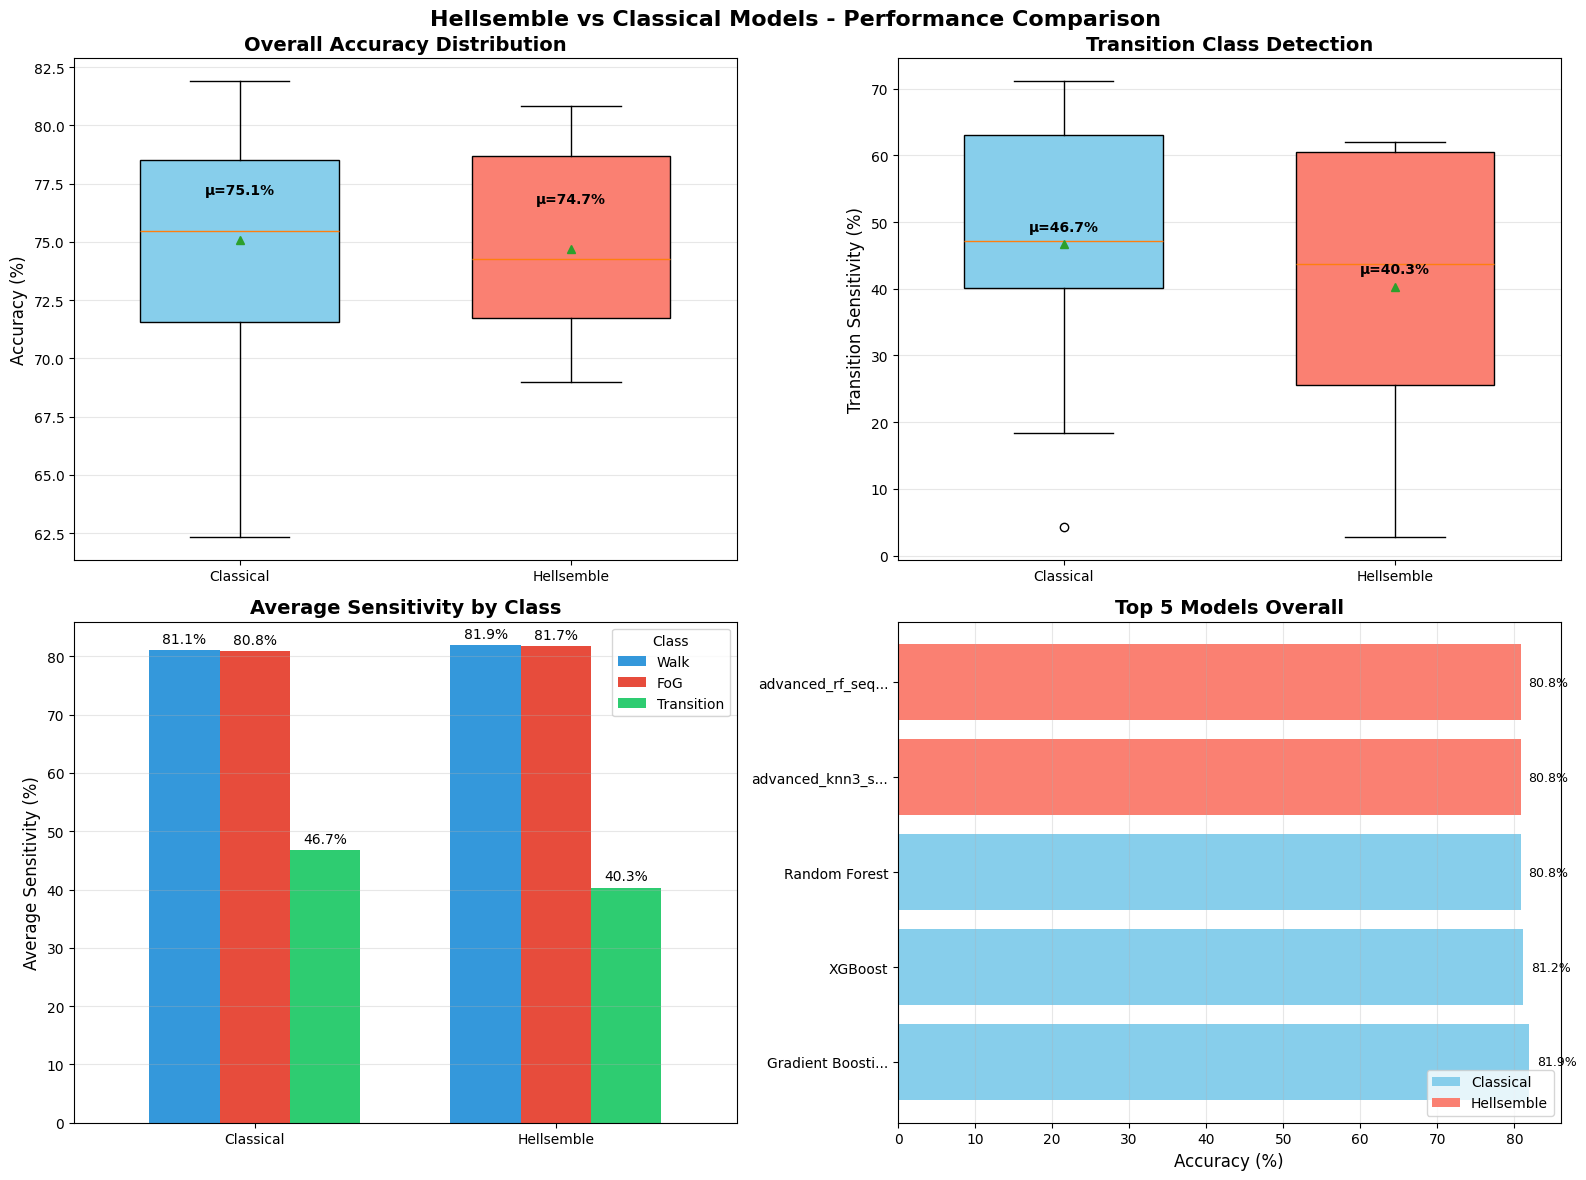


✅ Visualizations generated!

STATISTICAL COMPARISON

T-test for Accuracy Difference:
  Classical mean: 75.07%
  Hellsemble mean: 74.68%
  t-statistic: 0.2771
  p-value: 0.7830
  ⚠️ No statistically significant difference (p >= 0.05)

T-test for Transition Sensitivity Difference:
  Classical mean: 46.71%
  Hellsemble mean: 40.33%
  t-statistic: 1.0314
  p-value: 0.3081
  ⚠️ No statistically significant difference (p >= 0.05)

✅ COMPREHENSIVE COMPARISON COMPLETE!


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

print("="*80)
print("COMPREHENSIVE COMPARISON: HELLSEMBLE VS CLASSICAL MODELS")
print("="*80)

# ===== COLLECT ALL CLASSICAL MODEL RESULTS =====
# We'll extract results from your earlier experiments (results_2s_5feat, results_3s_15feat, results_4s_30feat)

classical_results = []

# From your earlier runs, we need to extract the results
# Let me create a function to properly structure the classical results

def extract_classical_results(results_dict, dataset_name):
    """Extract results from classical model evaluation dictionaries"""
    extracted = []
    for model_name, result in results_dict.items():
        metrics = result['metrics']
        extracted.append({
            'dataset': dataset_name,
            'model_type': 'Classical',
            'model': model_name,
            'accuracy': result['test_accuracy'],
            'trans_sens': metrics['Transition']['sensitivity'],
            'fog_sens': metrics['FoG']['sensitivity'],
            'walk_sens': metrics['Walk']['sensitivity'],
            'trans_spec': metrics['Transition']['specificity'],
            'fog_spec': metrics['FoG']['specificity'],
            'walk_spec': metrics['Walk']['specificity']
        })
    return extracted

# Extract classical results from your previous experiments
print("\n📊 Extracting classical model results from previous experiments...")

# You ran these earlier - we'll use the stored results
# results_2s_5feat, results_3s_15feat, results_4s_30feat

classical_2s = extract_classical_results(results_2s_5feat, '2s-5feat')
classical_3s = extract_classical_results(results_3s_15feat, '3s-15feat')
classical_4s = extract_classical_results(results_4s_30feat, '4s-30feat')

all_classical = classical_2s + classical_3s + classical_4s
classical_df = pd.DataFrame(all_classical)

print(f"✅ Extracted {len(classical_df)} classical model results")

# ===== PREPARE HELLSEMBLE RESULTS =====
hellsemble_df_formatted = hellsemble_results_df.copy()
hellsemble_df_formatted['model_type'] = 'Hellsemble'
hellsemble_df_formatted['model'] = (hellsemble_df_formatted['base_config'] + '_' +
                                     hellsemble_df_formatted['router'] + '_' +
                                     hellsemble_df_formatted['mode'])

# Add specificity columns (they exist in hellsemble_results_df)
hellsemble_comparison = hellsemble_df_formatted[['dataset', 'model_type', 'model', 'accuracy',
                                                   'trans_sens', 'fog_sens', 'walk_sens',
                                                   'trans_spec', 'fog_spec', 'walk_spec']]

print(f"✅ Prepared {len(hellsemble_comparison)} Hellsemble results")

# ===== COMBINE ALL RESULTS =====
all_results = pd.concat([classical_df, hellsemble_comparison], ignore_index=True)

print(f"\n📈 Total experiments: {len(all_results)}")
print(f"   Classical: {len(classical_df)}")
print(f"   Hellsemble: {len(hellsemble_comparison)}")

# ===== COMPARISON 1: BEST MODELS BY DATASET =====
print("\n" + "="*80)
print("COMPARISON 1: BEST OVERALL ACCURACY BY DATASET")
print("="*80)

for dataset in ['2s-5feat', '3s-15feat', '4s-30feat']:
    print(f"\n{'='*80}")
    print(f"Dataset: {dataset}")
    print(f"{'='*80}")

    dataset_results = all_results[all_results['dataset'] == dataset].copy()
    top_5 = dataset_results.nlargest(5, 'accuracy')

    print("\nTop 5 Models:")
    print(f"{'Rank':<6} {'Type':<12} {'Model':<30} {'Acc%':<8} {'Trans%':<8} {'FoG%':<8} {'Walk%':<8}")
    print("-"*80)

    for idx, (_, row) in enumerate(top_5.iterrows(), 1):
        model_name = row['model'][:28] if len(row['model']) > 28 else row['model']
        print(f"{idx:<6} {row['model_type']:<12} {model_name:<30} "
              f"{row['accuracy']*100:>6.2f}%  {row['trans_sens']:>6.2f}%  "
              f"{row['fog_sens']:>6.2f}%  {row['walk_sens']:>6.2f}%")

# ===== COMPARISON 2: BEST TRANSITION SENSITIVITY =====
print("\n" + "="*80)
print("COMPARISON 2: BEST TRANSITION CLASS SENSITIVITY")
print("="*80)

for dataset in ['2s-5feat', '3s-15feat', '4s-30feat']:
    print(f"\n{'='*80}")
    print(f"Dataset: {dataset}")
    print(f"{'='*80}")

    dataset_results = all_results[all_results['dataset'] == dataset].copy()
    top_5 = dataset_results.nlargest(5, 'trans_sens')

    print("\nTop 5 Models for Transition Detection:")
    print(f"{'Rank':<6} {'Type':<12} {'Model':<30} {'Trans%':<8} {'FoG%':<8} {'Walk%':<8} {'Acc%':<8}")
    print("-"*80)

    for idx, (_, row) in enumerate(top_5.iterrows(), 1):
        model_name = row['model'][:28] if len(row['model']) > 28 else row['model']
        print(f"{idx:<6} {row['model_type']:<12} {model_name:<30} "
              f"{row['trans_sens']:>6.2f}%  {row['fog_sens']:>6.2f}%  "
              f"{row['walk_sens']:>6.2f}%  {row['accuracy']*100:>6.2f}%")

# ===== COMPARISON 3: AVERAGE PERFORMANCE BY MODEL TYPE =====
print("\n" + "="*80)
print("COMPARISON 3: AVERAGE PERFORMANCE - CLASSICAL VS HELLSEMBLE")
print("="*80)

avg_by_type = all_results.groupby('model_type').agg({
    'accuracy': 'mean',
    'trans_sens': 'mean',
    'fog_sens': 'mean',
    'walk_sens': 'mean'
}).round(2)

print("\nAverage Performance:")
print(avg_by_type)

# ===== COMPARISON 4: BEST OF BEST =====
print("\n" + "="*80)
print("COMPARISON 4: OVERALL CHAMPIONS")
print("="*80)

print("\n🏆 OVERALL BEST ACCURACY:")
best_acc = all_results.nlargest(3, 'accuracy')
for idx, (_, row) in enumerate(best_acc.iterrows(), 1):
    print(f"{idx}. [{row['model_type']}] {row['model']} on {row['dataset']}: "
          f"{row['accuracy']*100:.2f}% (Trans: {row['trans_sens']:.2f}%)")

print("\n🎯 OVERALL BEST TRANSITION SENSITIVITY:")
best_trans = all_results.nlargest(3, 'trans_sens')
for idx, (_, row) in enumerate(best_trans.iterrows(), 1):
    print(f"{idx}. [{row['model_type']}] {row['model']} on {row['dataset']}: "
          f"{row['trans_sens']:.2f}% (Acc: {row['accuracy']*100:.2f}%)")

print("\n⚖️ MOST BALANCED PERFORMANCE (all classes > 60%):")
balanced = all_results[
    (all_results['trans_sens'] > 60) &
    (all_results['fog_sens'] > 60) &
    (all_results['walk_sens'] > 60)
].sort_values('accuracy', ascending=False).head(5)

if len(balanced) > 0:
    for idx, (_, row) in enumerate(balanced.iterrows(), 1):
        print(f"{idx}. [{row['model_type']}] {row['model']} on {row['dataset']}: "
              f"Acc {row['accuracy']*100:.2f}% | Trans {row['trans_sens']:.2f}% | "
              f"FoG {row['fog_sens']:.2f}% | Walk {row['walk_sens']:.2f}%")
else:
    print("No models achieved balanced performance (all classes > 60%)")

# ===== COMPARISON 5: DIRECT MATCHUPS =====
print("\n" + "="*80)
print("COMPARISON 5: DIRECT MATCHUP - BEST CLASSICAL VS BEST HELLSEMBLE")
print("="*80)

for dataset in ['2s-5feat', '3s-15feat', '4s-30feat']:
    print(f"\n{dataset.upper()}:")
    print("-"*80)

    dataset_results = all_results[all_results['dataset'] == dataset]

    best_classical = dataset_results[dataset_results['model_type'] == 'Classical'].nlargest(1, 'accuracy').iloc[0]
    best_hellsemble = dataset_results[dataset_results['model_type'] == 'Hellsemble'].nlargest(1, 'accuracy').iloc[0]

    print(f"\n{'Metric':<20} {'Classical Best':<30} {'Hellsemble Best':<30} {'Winner':<15}")
    print("-"*95)

    metrics = [
        ('Model', best_classical['model'][:28], best_hellsemble['model'][:28], '-'),
        ('Accuracy', f"{best_classical['accuracy']*100:.2f}%", f"{best_hellsemble['accuracy']*100:.2f}%",
         'Classical' if best_classical['accuracy'] > best_hellsemble['accuracy'] else 'Hellsemble'),
        ('Trans Sensitivity', f"{best_classical['trans_sens']:.2f}%", f"{best_hellsemble['trans_sens']:.2f}%",
         'Classical' if best_classical['trans_sens'] > best_hellsemble['trans_sens'] else 'Hellsemble'),
        ('FoG Sensitivity', f"{best_classical['fog_sens']:.2f}%", f"{best_hellsemble['fog_sens']:.2f}%",
         'Classical' if best_classical['fog_sens'] > best_hellsemble['fog_sens'] else 'Hellsemble'),
        ('Walk Sensitivity', f"{best_classical['walk_sens']:.2f}%", f"{best_hellsemble['walk_sens']:.2f}%",
         'Classical' if best_classical['walk_sens'] > best_hellsemble['walk_sens'] else 'Hellsemble'),
    ]

    for metric_name, classical_val, hellsemble_val, winner in metrics:
        print(f"{metric_name:<20} {classical_val:<30} {hellsemble_val:<30} {winner:<15}")

# ===== VISUALIZATION: PERFORMANCE COMPARISON =====
print("\n" + "="*80)
print("GENERATING VISUALIZATIONS...")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Hellsemble vs Classical Models - Performance Comparison', fontsize=16, fontweight='bold')

# Plot 1: Accuracy Distribution
ax1 = axes[0, 0]
classical_acc = classical_df['accuracy'] * 100
hellsemble_acc = hellsemble_comparison['accuracy'] * 100

positions = [1, 2]
bp = ax1.boxplot([classical_acc, hellsemble_acc], positions=positions, widths=0.6,
                  patch_artist=True, showmeans=True)
bp['boxes'][0].set_facecolor('skyblue')
bp['boxes'][1].set_facecolor('salmon')
ax1.set_xticks(positions)
ax1.set_xticklabels(['Classical', 'Hellsemble'])
ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax1.set_title('Overall Accuracy Distribution', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Add mean values as text
mean_classical = classical_acc.mean()
mean_hellsemble = hellsemble_acc.mean()
ax1.text(1, mean_classical + 2, f'μ={mean_classical:.1f}%', ha='center', fontsize=10, fontweight='bold')
ax1.text(2, mean_hellsemble + 2, f'μ={mean_hellsemble:.1f}%', ha='center', fontsize=10, fontweight='bold')

# Plot 2: Transition Sensitivity Distribution
ax2 = axes[0, 1]
classical_trans = classical_df['trans_sens']
hellsemble_trans = hellsemble_comparison['trans_sens']

bp2 = ax2.boxplot([classical_trans, hellsemble_trans], positions=positions, widths=0.6,
                   patch_artist=True, showmeans=True)
bp2['boxes'][0].set_facecolor('skyblue')
bp2['boxes'][1].set_facecolor('salmon')
ax2.set_xticks(positions)
ax2.set_xticklabels(['Classical', 'Hellsemble'])
ax2.set_ylabel('Transition Sensitivity (%)', fontsize=12)
ax2.set_title('Transition Class Detection', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

mean_classical_trans = classical_trans.mean()
mean_hellsemble_trans = hellsemble_trans.mean()
ax2.text(1, mean_classical_trans + 2, f'μ={mean_classical_trans:.1f}%', ha='center', fontsize=10, fontweight='bold')
ax2.text(2, mean_hellsemble_trans + 2, f'μ={mean_hellsemble_trans:.1f}%', ha='center', fontsize=10, fontweight='bold')

# Plot 3: Per-Class Sensitivity Comparison
ax3 = axes[1, 0]
class_metrics = pd.DataFrame({
    'Walk': [classical_df['walk_sens'].mean(), hellsemble_comparison['walk_sens'].mean()],
    'FoG': [classical_df['fog_sens'].mean(), hellsemble_comparison['fog_sens'].mean()],
    'Transition': [classical_df['trans_sens'].mean(), hellsemble_comparison['trans_sens'].mean()]
}, index=['Classical', 'Hellsemble'])

class_metrics.plot(kind='bar', ax=ax3, color=['#3498db', '#e74c3c', '#2ecc71'], width=0.7)
ax3.set_ylabel('Average Sensitivity (%)', fontsize=12)
ax3.set_title('Average Sensitivity by Class', fontsize=14, fontweight='bold')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0)
ax3.legend(title='Class', fontsize=10)
ax3.grid(axis='y', alpha=0.3)

# Add value labels on bars
for container in ax3.containers:
    ax3.bar_label(container, fmt='%.1f%%', padding=3)

# Plot 4: Best Models Comparison
ax4 = axes[1, 1]

# Get top 5 overall models
top_overall = all_results.nlargest(5, 'accuracy')
model_labels = [f"{row['model'][:15]}..." if len(row['model']) > 15 else row['model']
                for _, row in top_overall.iterrows()]
colors_list = ['skyblue' if row['model_type'] == 'Classical' else 'salmon'
               for _, row in top_overall.iterrows()]

bars = ax4.barh(range(len(top_overall)), top_overall['accuracy'] * 100, color=colors_list)
ax4.set_yticks(range(len(top_overall)))
ax4.set_yticklabels(model_labels)
ax4.set_xlabel('Accuracy (%)', fontsize=12)
ax4.set_title('Top 5 Models Overall', fontsize=14, fontweight='bold')
ax4.grid(axis='x', alpha=0.3)

# Add value labels
for i, (_, row) in enumerate(top_overall.iterrows()):
    ax4.text(row['accuracy'] * 100 + 1, i, f"{row['accuracy']*100:.1f}%",
             va='center', fontsize=9)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='skyblue', label='Classical'),
                   Patch(facecolor='salmon', label='Hellsemble')]
ax4.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

print("\n✅ Visualizations generated!")

# ===== STATISTICAL COMPARISON =====
print("\n" + "="*80)
print("STATISTICAL COMPARISON")
print("="*80)

from scipy import stats

# T-test for accuracy
t_stat, p_value = stats.ttest_ind(classical_df['accuracy'], hellsemble_comparison['accuracy'])
print(f"\nT-test for Accuracy Difference:")
print(f"  Classical mean: {classical_df['accuracy'].mean()*100:.2f}%")
print(f"  Hellsemble mean: {hellsemble_comparison['accuracy'].mean()*100:.2f}%")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_value:.4f}")
if p_value < 0.05:
    print(f"  ✅ Statistically significant difference (p < 0.05)")
else:
    print(f"  ⚠️ No statistically significant difference (p >= 0.05)")

# T-test for transition sensitivity
t_stat_trans, p_value_trans = stats.ttest_ind(classical_df['trans_sens'], hellsemble_comparison['trans_sens'])
print(f"\nT-test for Transition Sensitivity Difference:")
print(f"  Classical mean: {classical_df['trans_sens'].mean():.2f}%")
print(f"  Hellsemble mean: {hellsemble_comparison['trans_sens'].mean():.2f}%")
print(f"  t-statistic: {t_stat_trans:.4f}")
print(f"  p-value: {p_value_trans:.4f}")
if p_value_trans < 0.05:
    print(f"  ✅ Statistically significant difference (p < 0.05)")
else:
    print(f"  ⚠️ No statistically significant difference (p >= 0.05)")

print("\n" + "="*80)
print("✅ COMPREHENSIVE COMPARISON COMPLETE!")
print("="*80)